# eCommerce behavior data from multi category store using pyspark

### Te cell below connects the notebook pyspark to the created cluster

In [1]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import to_timestamp, to_date, date_format
import seaborn as sns

spark = SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

### Next steps
1. Create a variable that will have the path to the data
2. Define the schema of the table for the read CSV to be faster

In [2]:
# 1.
data_pth_1 = "/opt/workspace/data/2019-Nov.csv"
data_pth_2 = "/opt/workspace/data/2019-Oct.csv"

In [3]:
# 2. To define the schema of the data I must import the StructType, because it acelerates the data reading
data_sch = StructType([StructField("event_time", StringType(),   True),
                       StructField("event_type", StringType(), True),
                       StructField("product_id", LongType(),   True),
                       StructField("category_id", LongType (), True),
                       StructField("category_code", StringType(), True),
                       StructField("brand", StringType(),      True),
                       StructField("price", DoubleType(),      True),
                       StructField("user_id", LongType(),      True),
                       StructField("user_session", StringType(), True)])

In [4]:
oct_df = spark.read \
    .option("header",True) \
    .csv(data_pth_2, schema=data_sch)

In [5]:
# Create the date and weekday column
oct_df = oct_df.withColumn('event_time_day', to_date(oct_df.event_time, 'yyyy-MM-dd')) \
               .withColumn('event_time_wd' , date_format(oct_df.event_time, 'E')) 

In [6]:
nov_df = spark.read \
    .option("header",True) \
    .csv(data_pth_1, schema=data_sch)

In [7]:
nov_df = nov_df.withColumn('event_time_day',to_date(nov_df.event_time, 'yyyy-MM-dd')) \
               .withColumn('event_time_wd', date_format(nov_df.event_time, 'E'))

In [8]:
# Show columns
oct_df.columns

['event_time',
 'event_type',
 'product_id',
 'category_id',
 'category_code',
 'brand',
 'price',
 'user_id',
 'user_session',
 'event_time_day',
 'event_time_wd']

In [9]:
# Show datatypes on each column
oct_df.dtypes

[('event_time', 'string'),
 ('event_type', 'string'),
 ('product_id', 'bigint'),
 ('category_id', 'bigint'),
 ('category_code', 'string'),
 ('brand', 'string'),
 ('price', 'double'),
 ('user_id', 'bigint'),
 ('user_session', 'string'),
 ('event_time_day', 'date'),
 ('event_time_wd', 'string')]

### Start to answering the business questions
1. On what date do customers shop the most?

In [10]:
oct_df_x = oct_df.filter(oct_df.event_type == 'purchase') \
    .groupBy(oct_df.event_time_day) \
    .agg({"event_time": "count"}) \
    .sort('count(event_time)', ascending=False)

In [11]:
gdf_final = oct_df_x.unionAll( nov_df.filter(nov_df.event_type == 'purchase') \
    .groupBy(nov_df.event_time_day) \
    .agg({"event_time": "count"}) \
    .sort('count(event_time)', ascending=False))
gdf_final.cache()

DataFrame[event_time_day: date, count(event_time): bigint]

In [35]:
ps_df = ps.DataFrame(gdf_final)
type(ps_df)

pyspark.pandas.frame.DataFrame

In [46]:
# Sorting
ps_df_s = ps_df.sort_values(by='count(event_time)', ascending=False)
ps_df_s_i = ps_df_s.reset_index(drop=True)

AxesSubplot(0.125,0.125;0.775x0.755)


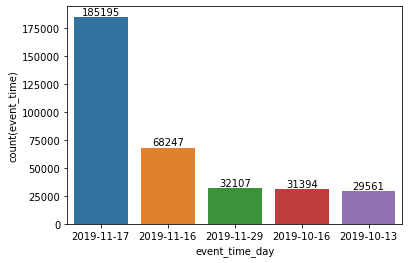

In [48]:
ax = sns.barplot(x='event_time_day', 
                 y='count(event_time)', 
                 data = ps_df_s_i.query('__index_level_0__ <= 4').to_pandas())
ax.bar_label(ax.containers[0])
print(ax.)